In [1]:
import pandas as pd

In [2]:
from datetime import datetime, timedelta

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [66]:
# import dowhy
from dowhy import CausalModel

In [67]:
from IPython.display import Image, display

In [4]:
pd.set_option("mode.chained_assignment", None)

In [5]:
from futil import * 

In [6]:
wdi_df, series_df = load_wdi()

In [7]:
project_df = load_projects()
wb_df = extract_wb_projects(project_df)

So use:

* GDP at current USD, from WDI
* Multiply by % of GDP
* Compare to WB loan size

In [8]:
relevant_codes = {
    'GDP_current_USD': 'NY.GDP.MKTP.CD',
    'GovtExpenses_current_USD': 'GC.XPN.TOTL.GD.ZS'
}

wb_extract = extract_indicators(wdi_df, relevant_codes.values())

expense_df = wb_extract[wb_extract['Indicator Code'] == 'GC.XPN.TOTL.GD.ZS']

In [9]:
feature_indicators = [
    'DT.ODA.ODAT.GN.ZS',
    'NY.GDP.MKTP.CD' # divide project size at time
]

In [10]:
education_expense_indicators = [
    'SE.XPD.PRIM.ZS',
    'SE.XPD.SECO.ZS',
    'SE.XPD.TERT.ZS'
]

## Constructing time gaps

In [11]:
sector_aggs = project_df.groupby('sector').agg(
    number_projects=('ppd_project_id', 'nunique'),
    earliest_year=('start_dt', 'min'),
    latest_project=('start_dt', 'max'),
    number_donors=('donor_name', 'nunique'),
    avg_rating=('six_overall_rating', 'mean'),
    avg_duration=('project_duration', 'mean')
)

In [12]:
feature_cols = [
    'country_code', 
    'donor_name', 
    'aiddata_sectorname', 
    'six_overall_rating', 
    'start_date', 
    'completion_date', 
    'project_duration',
    'sector'
]

In [13]:
pdf = narrow_convert_project_data(project_df, feature_cols)

<AxesSubplot:>

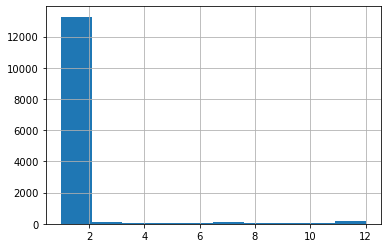

In [14]:
pdf.completion_dt.dt.month.hist()

In [15]:
total_countries = pdf.country_code.nunique()
earliest_year = pdf.start_year.min()
latest_year = pdf.start_year.max()
year_range = range(int(earliest_year), int(latest_year))

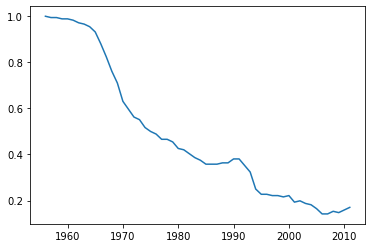

In [16]:
fig, ax = plt.subplots()
ax.plot(year_range, count_countries_in_window(pdf, year_range, year_lag=0))

(0.0, 1.0)

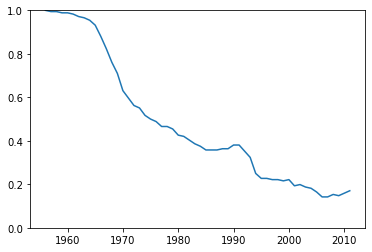

In [17]:
fig, ax = plt.subplots()
ax.plot(year_range, count_countries_in_window(pdf, year_range))
ax.set_ylim([0, 1])

(0.0, 1.0)

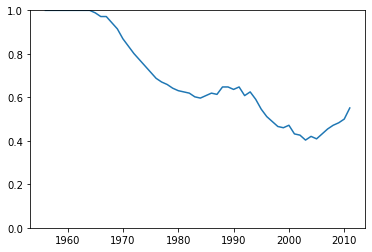

In [18]:
fig, ax = plt.subplots()
ax.plot(year_range, count_countries_in_window(pdf, year_range, year_lag=5, in_sector='Education'))
ax.set_ylim([0, 1])

** In other words: can only get to binary using sectors

In [19]:
assemble_sector_dict = lambda sector: dict(zip(year_range, count_countries_in_window(pdf, year_range, year_lag=5, in_sector=sector)))
# mean_sector_treat = lambda sector: 

In [20]:
def calc_sector_post_year_gaps(sector, year):
    sector_post_year = [value for key, value in assemble_sector_dict(sector).items() if key >= year]
    mean_post_year = sum(sector_post_year) / len(sector_post_year)
    return mean_post_year

In [21]:
calc_sector_post_year_gaps('Education', 1990)

0.5015495867768593

## Assemble dataframe

In [22]:
def get_countries_with_active(pdf, year, year_lag=5, in_sector=None):
    ref_year = datetime(year, 1, 1)
    
    active_mask = pdf.start_dt < ref_year
    lag_mask = (pdf.completion_dt + timedelta(days=(year_lag*365))) > ref_year
    active_plus_lag_mask = active_mask & lag_mask
    sector_mask = pdf.sector == in_sector
    
    final_mask = (active_plus_lag_mask & sector_mask) if in_sector is not None else active_plus_lag_mask
    
    return pdf[final_mask].country_code.unique()

In [23]:
get_countries_with_active(pdf, 2000, in_sector='Education')

array(['BNG', 'INS', 'CAM', 'MSI', 'LAO', 'KZK', 'UZB', 'COO', 'MON',
       'KYR', 'PHI', 'PNG', 'THI', 'DRV', 'NEP', 'PAK', 'MLD', 'SRI',
       'BHU', 'MAL', 'JOR', 'CHN', 'BUI', 'MLI', 'SAL', 'HON', 'NIC',
       'CHL', 'GUA', 'SEN', 'TUN', 'NIR', 'CHA', 'CDI', 'ISR', 'EGY',
       'BOL', 'ECU', 'PER', 'ERI', 'DOM', 'MAW', 'GHA', 'ETH', 'IND',
       'GUI', 'NAM', 'YEM', 'WBG', 'UGA', 'LES', 'NIG', 'ZIM', 'ARG',
       'ALG', 'TUR', 'CAP', 'MOR', 'BAR', 'BFO', 'BRA', 'BLZ', 'MZM',
       'COL', 'COS', 'DJI', 'DMA', 'LAT', 'TAZ', 'AZE', 'MAG', 'MAA',
       'TAJ', 'VAN', 'MAD', 'BEN', 'ANG', 'SIE', 'ROM', 'ZAM', 'MAS',
       'POL', 'HUN', 'MEX', 'JAM', 'LEB', 'KEN', 'PAN', 'PAR', 'TOG',
       'ALB', 'SLU', 'URU'], dtype=object)

In [24]:
all_countries = pdf.country_code.unique()

In [25]:
len(all_countries)

176

In [26]:
len(get_countries_with_active(pdf, 2000, in_sector='Education'))

93

## First approach: binary treatment, simple, education

### Assemble education indicator frame

In [27]:
# for each country-year, calculate mean growth in education indicators at year + lag

In [175]:
def assemble_sectoral_df(load_persisted=True):
    # first, assemble DF from cross product of country codes and all years
    df = pd.DataFrame(index = pd.MultiIndex.from_product([year_range, all_countries], names=["year", "country"])).reset_index()

    # second, look up education indicators at years + lag, after interpolating
    edu_indicators = ['SE.PRM.NENR',
                      'SE.PRM.CMPT.ZS',
                      'SE.PRM.PRSL.ZS']

    mdf = pd.read_csv('../data/MDGData.csv')
    edf = mdf[mdf['Indicator Code'].isin(edu_indicators)]
    tdf = edf.drop(
        columns=["Country Name", "Indicator Name", "Unnamed: 30"]
    ).melt(
        id_vars=['Country Code', 'Indicator Code'],
        var_name="Year"
    )

    tdf['Year'] = tdf['Year'].astype(int)
    
    if load_persisted:
        df = df.read_csv('../data/transformed_df/education.csv')
    
    return df, tdf

In [37]:
df, tdf = assemble_sectoral_df()
# tdf.head()

,Country Code,Indicator Code,Year,value
0,ARB,SE.PRM.PRSL.ZS,1990,84.182720
1,ARB,SE.PRM.CMPT.ZS,1990,68.912369
2,ARB,SE.PRM.NENR,1990,72.386398
3,CSS,SE.PRM.PRSL.ZS,1990,83.209790
4,CSS,SE.PRM.CMPT.ZS,1990,94.996964


In [38]:
# stubbing out for some later interpolation

In [39]:
ug_df = tdf[(tdf['Country Code'] == 'UGA') & (tdf['Indicator Code'] == 'SE.PRM.PRSL.ZS')]
ug_df = ug_df.set_index('Year')

<AxesSubplot:xlabel='Year'>

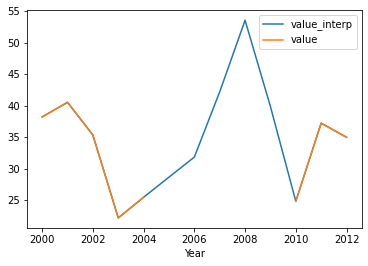

In [188]:
ug_df['value_interp'] = ug_df['value'].interpolate(method='akima')
ug_df.plot.line(y=['value_interp', 'value'])

In [43]:
# third, obtain the average; now have the response

In [44]:
def add_edu_lag_and_count(row, lag):
    lag_avg, lag_count = get_avg_indicator_with_lag(tdf, row['country'], row['year'], edu_indicators, lag)
    row['edu_lag_' + str(lag) + '_growth'] = lag_avg
    row['edu_lag_' + str(lag) + '_count'] = lag_count
    return row

In [45]:
get_avg_indicator_with_lag(tdf, 'UGA', 2000, edu_indicators, 6)

(0.8334471820033446, 1)

In [176]:
for lag in range (1, 10):
    if 'edu_lag_' + str(lag) + '_growth' not in df.columns:
        df = df.apply(lambda row: add_edu_lag_and_count(row, lag), axis=1)

In [178]:
prior_offset= 4
if 'edu_lag_' + str(-prior_offset) + '_growth':
    df = df.apply(lambda row: add_edu_lag_and_count(row, -4), axis=1)

In [58]:
df.head()

,year,country,edu_lag_5_growth,edu_lag_5_count,edu_lag_6_growth,edu_lag_6_count,edu_lag_7_growth,edu_lag_7_count,edu_lag_8_growth,edu_lag_8_count,...,edu_lag_1_growth,edu_lag_1_count,edu_lag_2_growth,edu_lag_2_count,edu_lag_3_growth,edu_lag_3_count,edu_lag_4_growth,edu_lag_4_count,edu_lag_-4_growth,edu_lag_-4_count
0,1956,CHN,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,1956,COO,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,1956,PHI,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3,1956,NEP,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
4,1956,SRI,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0


In [55]:
for i in range(1, 10):
    print(f"Number of observations at lag {i} is: {df['edu_lag_' + str(i) + '_growth'].notna().sum()}")

Number of observations at lag 1 is: 930
Number of observations at lag 2 is: 917
Number of observations at lag 3 is: 904
Number of observations at lag 4 is: 902
Number of observations at lag 5 is: 849
Number of observations at lag 6 is: 801
Number of observations at lag 7 is: 747
Number of observations at lag 8 is: 707
Number of observations at lag 9 is: 664


<AxesSubplot:>

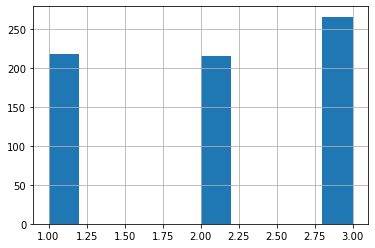

In [61]:
df[df['edu_lag_-4_count'] > 0]['edu_lag_-4_count'].hist()

<AxesSubplot:>

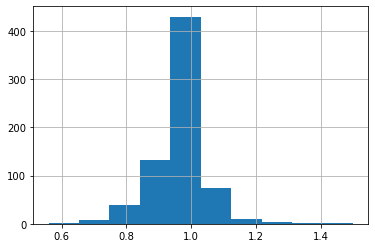

In [62]:
df[df['edu_lag_-4_count'] > 0]['edu_lag_-4_growth'].hist()

In [ ]:
# fourth, add in whether or not a project completed in that year

In [179]:
eproj = pdf[pdf.sector == 'Education']

def is_project_complete_year(year, country, sp_df):
    country_proj = sp_df[sp_df['country_code'] == country].end_year.to_list()
    return year in country_proj

In [180]:
if 'project_completed_year' not in df.columns:
    df['project_completed_year'] = df.apply(lambda row: is_project_complete_year(row['year'], row['country'], eproj), axis=1)

In [181]:
df.head()

,year,country,edu_lag_5_growth,edu_lag_5_count,edu_lag_6_growth,edu_lag_6_count,edu_lag_7_growth,edu_lag_7_count,edu_lag_8_growth,edu_lag_8_count,...,edu_lag_3_growth,edu_lag_3_count,edu_lag_4_growth,edu_lag_4_count,edu_lag_-4_growth,edu_lag_-4_count,project_completed_year,most_recent_govt_rating,sector_delta_prior,sector_delta_post
0,1956,CHN,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,False,NaN,NaN,NaN
1,1956,COO,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,False,NaN,NaN,NaN
2,1956,PHI,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,False,NaN,NaN,NaN
3,1956,NEP,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,False,NaN,NaN,NaN
4,1956,SRI,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,False,NaN,NaN,NaN


In [182]:
write_df = False

if write_df:
    df.to_csv('../data/transformed_data/education_df.csv')

In [183]:
df[df.edu_lag_4_count > 0].project_completed_year.value_counts()

False    741
True     161
Name: project_completed_year, dtype: int64

In [ ]:
# remove: years within the influence of a project, i.e., during its initation and up to the lag period

In [ ]:
# then: add in the various confounders, treatments, controlsc

In [184]:
len(pdf)

In [185]:
df[(df.edu_lag_4_count > 0) & (df.project_completed_year)].head()

,year,country,edu_lag_5_growth,edu_lag_5_count,edu_lag_6_growth,edu_lag_6_count,edu_lag_7_growth,edu_lag_7_count,edu_lag_8_growth,edu_lag_8_count,...,edu_lag_3_growth,edu_lag_3_count,edu_lag_4_growth,edu_lag_4_count,edu_lag_-4_growth,edu_lag_-4_count,project_completed_year,most_recent_govt_rating,sector_delta_prior,sector_delta_post
6061,1990,JOR,NaN,0,0.998454,1,NaN,0,NaN,0,...,1.009747,1,1.039520,1,NaN,0,True,5.0,NaN,1.039520
6111,1990,TUN,1.084337,3,1.061001,3,1.052491,2,1.109765,1,...,1.003544,3,1.039468,3,NaN,0,True,5.0,NaN,1.039468
6240,1991,MEX,1.065398,3,1.044746,2,1.070365,2,1.084939,3,...,1.043643,3,1.062694,3,NaN,0,True,5.0,NaN,1.062694
6306,1991,DJI,1.079301,2,1.002846,2,NaN,0,0.968544,2,...,1.065767,2,1.131585,2,NaN,0,True,2.0,NaN,1.131585
6336,1992,CHN,0.923874,2,NaN,0,NaN,0,NaN,0,...,0.992914,3,0.977998,3,NaN,0,True,6.0,NaN,0.977998


In [110]:
project_df.head()

,ppd_project_id,donor_name,six_overall_rating,country_code,office_presence,project_duration,eval_lag,crs_purpose_code,crs_purpose_sector,aid_type,...,mmg_purpose_code,mmg_purpose_codename,wb_project_id,gfatm_project_id,giz_project_id,start_dt,start_year,completion_dt,end_year,sector
0,1,AsianDB,4.5,CHN,1.0,2555.0,730.0,NaN,NaN,NaN,...,140,WATER AND SANITATION,NaN,NaN,NaN,1996-11-26,1996.0,2003-01-01,2003.0,Wash
1,2,AsianDB,4.5,COO,0.0,1825.0,0.0,22040.0,220.0,L,...,220,COMMUNICATION,NaN,NaN,NaN,1990-09-20,1990.0,1995-01-01,1995.0,Telecom
2,3,AsianDB,1.5,PHI,1.0,2190.0,730.0,NaN,NaN,NaN,...,140,WATER AND SANITATION,NaN,NaN,NaN,1989-01-24,1989.0,1995-01-01,1995.0,Wash
3,4,AsianDB,4.5,NEP,1.0,6570.0,1095.0,21050.0,210.0,L,...,210,TRANSPORT AND STORAGE,NaN,NaN,NaN,1978-12-22,1978.0,1996-01-01,1996.0,Transport
4,5,AsianDB,4.5,SRI,1.0,1825.0,0.0,24010.0,240.0,L,...,240,BANKING AND FINANCIAL SERVICES,NaN,NaN,NaN,1991-07-23,1991.0,1996-01-01,1996.0,Finance


In [119]:
print(extract_indic_name_definition(series_df, 'budget'))

        Series Code                                     Indicator Name  \
383  GF.XPD.BUDG.ZS  Primary government expenditures as a proportio...   
477  IQ.CPA.FINQ.XQ  CPIA quality of budgetary and financial manage...   

                                       Long definition  
383  Primary government expenditures as a proportio...  
477  Quality of budgetary and financial management ...  


In [121]:
calculate_ratio_na(wdi_df, 'IQ.CPA.FINQ.XQ', df.country) # too high

In [186]:
def find_latest_govt_rating(country, year):
    country_proj = project_df[
        (project_df['country_code'] == country) 
        & (project_df['start_year'] <= year)
        & (project_df['wb_government_partner_rating'].notna())]
    if len(country_proj) == 0:
        return np.nan
    else:
        proj_year = country_proj[country_proj.start_year == country_proj.start_year.max()]
        return proj_year['wb_government_partner_rating'].sort_values(ascending=False).iloc[0]
#     return country_proj[['start_year', 'wb_government_partner_rating']]

In [187]:
if 'most_recent_govt_rating' not in df:
    df['most_recent_govt_rating'] = df.apply(lambda row: find_latest_govt_rating(row['country'], row['year']), axis=1)

In [148]:
df.most_recent_govt_rating.value_counts()

5.0    1655
2.0     403
4.0     306
6.0     205
3.0     156
1.0      11
Name: most_recent_govt_rating, dtype: int64

# Execute do-why

In [150]:
df['sector_delta_prior'] = df['edu_lag_-4_growth']
df['sector_delta_post'] = df['edu_lag_4_growth']

In [164]:
sectoral_effect_graph_binary = """digraph { 
    "Govt-Quality"[latent];
    project_completed_year [exposure, label="project_completed"];
    sector_delta_prior [adjusted, label="sector_outcome_growth_prior"];
    sector_delta_post [outcome, label=sector_outcome_growth_lagged];
    most_recent_govt_rating [label="WBGovtRating"];
    "Govt-Quality" -> project_completed_year;
    "Govt-Quality" -> sector_delta_prior;
    "Govt-Quality" -> most_recent_govt_rating;
    project_completed_year -> sector_delta_post;
    sector_delta_prior -> sector_delta_post;
    most_recent_govt_rating -> project_completed_year;
    }"""

In [151]:
causal_columns = ['sector_delta_prior', 'most_recent_govt_rating', 'project_completed_year', 'sector_delta_post']

In [152]:
causal_df = df[causal_columns]
pre_drop_N = len(causal_df)
causal_df = causal_df.dropna()
post_drop_N = len(causal_df)

print("N pre NA drop: ", pre_drop_N, " and post: ", post_drop_N)

N pre NA drop:  9856  and post:  418


In [172]:
causal_df.project_completed_year.value_counts()

False    315
True     103
Name: project_completed_year, dtype: int64

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. Invalid Input
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['project_completed_year'] on outcome ['sector_delta_post']


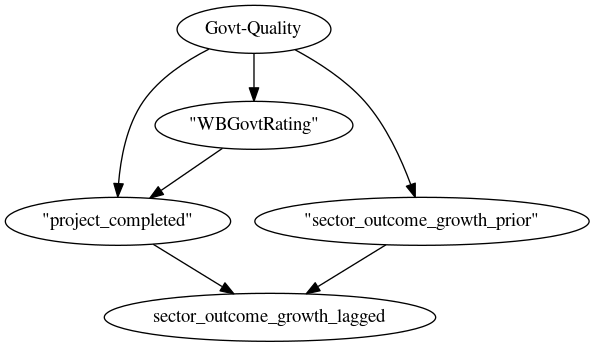

In [168]:
model = CausalModel(
    data=causal_df,
    graph=sectoral_effect_graph_binary.replace("\n", " "),
    treatment="project_completed_year",
    outcome="sector_delta_post"
)

model.view_model()
display(Image(filename="causal_model.png"))

In [169]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
            d                                                                 
─────────────────────────(Expectation(sector_delta_post|sector_delta_prior,mos
d[project_completed_year]                                                     

                      
t_recent_govt_rating))
                      
Estimand assumption 1, Unconfoundedness: If U→{project_completed_year} and U→sector_delta_post then P(sector_delta_post|project_completed_year,sector_delta_prior,most_recent_govt_rating,U) = P(sector_delta_post|project_completed_year,sector_delta_prior,most_recent_govt_rating)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [171]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",
                                 target_units="ate", test_significance=True)
print(estimate)

INFO:dowhy.causal_estimator:b: sector_delta_post~project_completed_year+sector_delta_prior+most_recent_govt_rating+project_completed_year*sector_delta_prior
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: sector_delta_post~project_completed_year+sector_delta_prior+most_recent_govt_rating+project_completed_year*sector_delta_prior
Target units: ate

## Estimate
Mean value: 0.012000683582671146
p-value: [0.00015782]
### Conditional Estimates
__categorical__sector_delta_prior
(0.559, 0.907]   -0.040718
(0.907, 0.971]    0.002391
(0.971, 0.995]    0.018588
(0.995, 1.017]    0.027871
(1.017, 1.5]      0.051946
dtype: float64
